<a href="https://colab.research.google.com/github/HafsaOuaj/-Clean-and-Analyze-Employee-Exit-Surveys/blob/main/image_captioning_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 style="text-align:center;color:pink">Image captioning using Transformers<h1/>

## Import the required packages

In [1]:
!git clone https://github.com/HafsaOuaj/Image-Captioning-using-Transformers.git

Cloning into 'Image-Captioning-using-Transformers'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [2]:
%cd Image-Captioning-using-Transformers

/content/Image-Captioning-using-Transformers


In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import  keras.preprocessing.sequence
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


## Data loading and Preprocessing

We will use the Flicker8k dataset from Kaggle. The dataset contains images and

In [ ]:
image_path="/kaggle/input/flickr30k/flickr30k_images"
caption_path="/kaggle/input/flickr30k/captions.txt"
images=os.listdir(image_path)
print("Total number of images = {} ".format(len(images)))

Total number of images = 31783 


There are 31783 images in the data set we have

In [ ]:
file=open(caption_path,'r')
text=file.read()
file.close()

datatxt=[]

for line in text.split('\n'):
       col = line.split(',')
       if len(col) < 3:
           continue

       datatxt.append([col[0],col[1],col[2].lower()])

data = pd.DataFrame(datatxt[1:],columns=["filename","index","caption"])
captions_data = data.reindex(columns =['index','filename','caption'])
uni_filenames = np.unique(data.filename.values)

data.head(),data.info(),captions_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  158915 non-null  object
 1   index     158915 non-null  object
 2   caption   158915 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


(         filename index                                            caption
 0  1000092795.jpg     0  two young guys with shaggy hair look at their ...
 1  1000092795.jpg     1  two young  white males are outside near many b...
 2  1000092795.jpg     2   two men in green shirts are standing in a yard .
 3  1000092795.jpg     3       a man in a blue shirt standing in a garden .
 4  1000092795.jpg     4            two friends enjoy time spent together .,
 None,
        index        filename  \
 0          0  1000092795.jpg   
 1          1  1000092795.jpg   
 2          2  1000092795.jpg   
 3          3  1000092795.jpg   
 4          4  1000092795.jpg   
 ...      ...             ...   
 158910     0   998845445.jpg   
 158911     1   998845445.jpg   
 158912     2   998845445.jpg   
 158913     3   998845445.jpg   
 158914     4   998845445.jpg   
 
                                                   caption  
 0       two young guys with shaggy hair look at their ...  
 1       two you

Let's visualize sime image with ther captions

(224, 224)
(224, 224)
(224, 224)
(224, 224)


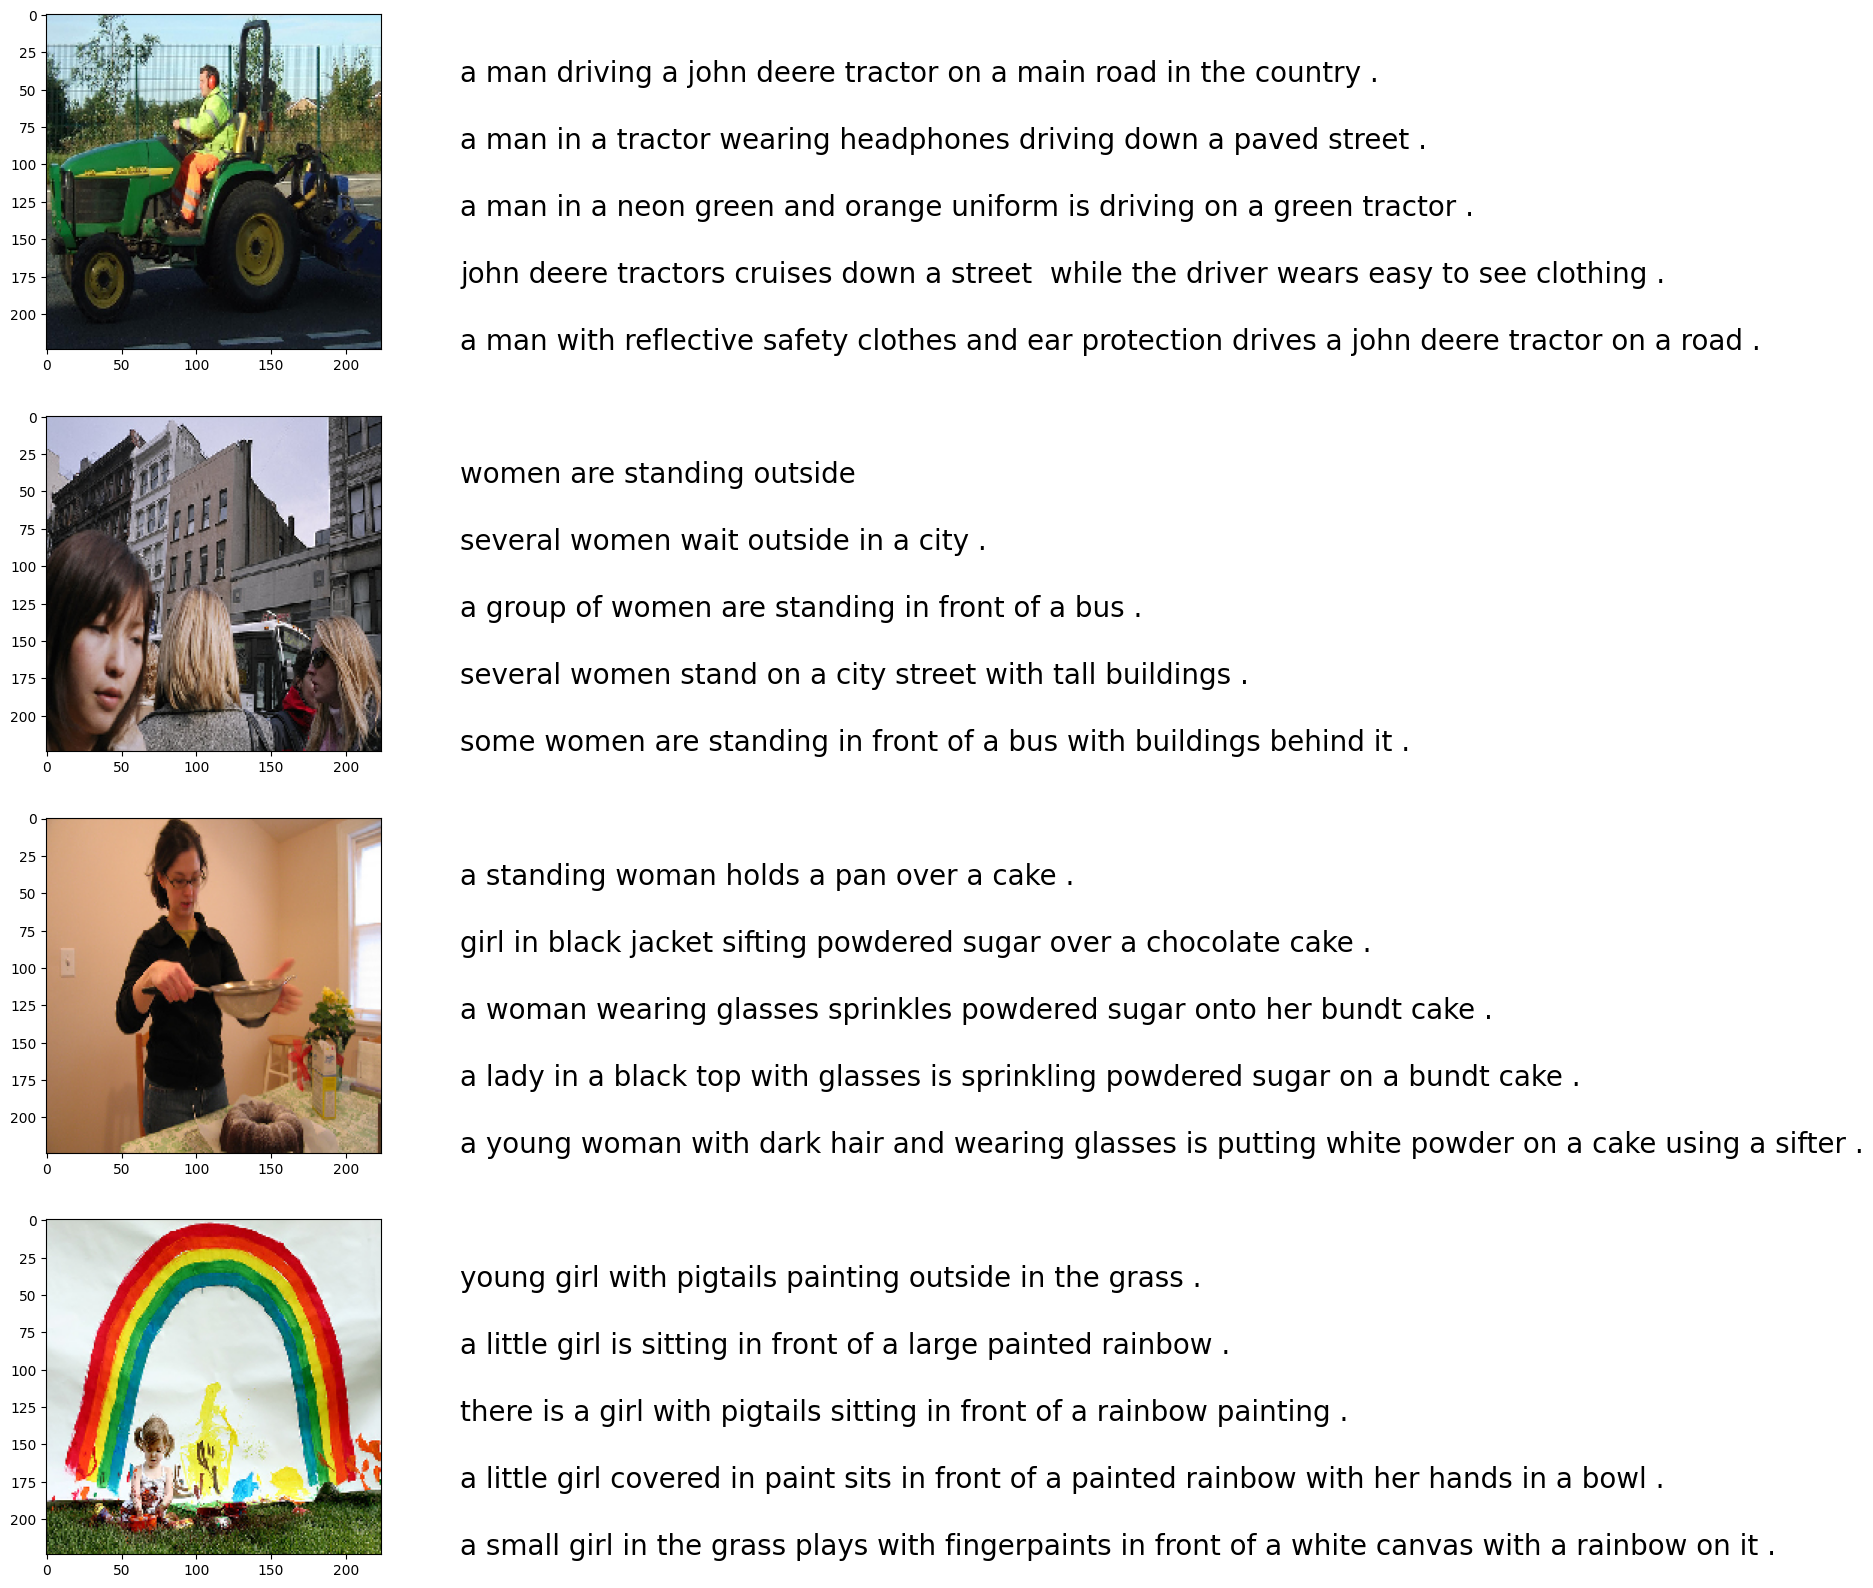

In [ ]:
Nbre=4
npixel=224
target_size=(npixel,npixel,3)
count=1

fig=plt.figure(figsize=(10,20))
for file in uni_filenames[13:17]:
        file_name=image_path+'/'+file
        captions=list(captions_data["caption"].loc[captions_data["filename"]==file].values)

        image_load=load_img(file_name,target_size=target_size)
        print(image_load.size)
        ax=fig.add_subplot(Nbre,2,count)
        ax.imshow(image_load)
        count+=1

        ax = fig.add_subplot(Nbre,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
               ax.text(0,i,caption,fontsize=20)

        count += 1
plt.show()



For each image there are five captions that describe it

### Vocabulary

In [ ]:
vocabulary= []

for txt in data.caption.values:
    vocabulary.extend(text.split())



print('Vocabulary size : {}'.format(vocabulary.size))


In [ ]:
def remove_punctuation(text_origin):
    text_no_pun=text_origin.translate(string.punctation)
    return text_no_pun